## Packages

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import math
import itertools
import random

# Plotting
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

# Statsmodels for statistical models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA as ARIMA_model
from statsmodels.tsa.arima.model import ARIMA

# PMDARIMA for auto ARIMA
import pmdarima as pm

# Scipy for scientific computing
import scipy

# TwoPiece for specific distributions
from twopiece.scale import tpnorm

# Register matplotlib converters
register_matplotlib_converters()

# Progress bar
from tqdm import tqdm

from  pydynpd import regression
from linearmodels import PanelOLS

## Data processing

### database's gathering

In [2]:
dfislac2 = pd.read_excel("FISLAC_update.xlsx")

In [3]:
# Fiscal Sustainability 
# To address how ENDES could affect fiscal sustainability we recur to an Extreme Bound Analysis (EBA). This methodology allows us to test the global sensitivity of our estimations examining the robustness of the relation between dependent and a set of possible determinants. Our approach strikes a balance between the Leamer (1985) approach, which focuses on the upper and lower limits of the estimations, and the more flexible Sala-I-Martin (1997) framework, which considers the complete distribution of the estimated coefficients (see also Hlavac 2016).
# In the context of this study, the EBA allows us to derive robust estimation considering various functional forms for the fiscal reaction function (FRF). Across the literature, the relation between primary balance and debt has been assumed as linear, quadratic, or cubic (see for example Di Iorio and Fachin 2022, Barti et al. 2016, Gosh et al. 2013, or Jooste et al. 2011, among others). The general FRF can be described as:
# 〖pb〗_(i,t)=ϕ_i+μ_t+β_1 d_(i,t-1)+α_1 N_(it-1)+α_2 〖dN〗_(i,t-1)+f(d_(it-1),N_(it-1)  )+EBA+e_it
# with EBA= ∑_(h=1)^k▒(∑_(x_j∈S)^(C_h)▒〖ϕ_(j,S) x_it 〗) 

# Where 〖pb〗_(i,t) and d_(i,t-1) represents primary balance and gross debt as percentage of GPD in t and t-1 respectively. N is a dummy equal to 1 if country i at year t-1 had an ENDE. The function f(d_(it-1),〖ND〗_(it-1)  ) considers non-linear terms of ND_(it-1) and d_(it-1) to study high orders in the FRF.  These could be:
# 	f_quadratic  =  d_(i,t-1)^2 (  β_2+α_3 N_(i,t-1) ) 
# 	f_cubic  =  d_(i,t-1)^2 (β_2+β_3 d_(i,t-1)+α_3 N_(i,t-1)+α_4 dN_(i,t-1) ) 
# The key term is the EBA component: ∑_(x_j∈S)^(C_q)▒〖ϕ_(j,S) x_it 〗, where specific variables and coefficients associated with subsets of control variables are considered. To clarify:
# 	The complete set of control variables, X, contains k variables. From this set, subsets S are formed, which represent all possible combinations of control variables that could be included in the regression model.
# 	Let 𝑆 be a subset of 𝑋 (S⊆X). The subset S includes combinations of 1,2,3,…,k variables. Formally, 𝑆 belongs to the set of all possible combinations of q variables from k, represented as S ∈(■(k@q)). This denotes the combinatorial selection of any q elements from k possible, calculated by C_q  =  k!/q!(k-q)!. All the possible combinations are ∑_(h=1)^k▒C_h .
# 	In this setting,  x_it  represents the covariates from all these possible combinations within S, which can be as many as C_q  , given q elements that can be selected. ϕ_(j,S) are the potential coefficients corresponding to each variable within a given combination j of S.
# X is composed by 15 macroeconomic, fiscal, and institutional indicators (for a detailed list please refer to Table A.1). Consequently, considering the three different functional form for the FRF mentioned and the diverse combinations of control variables, we could estimate XXX regressions selected from all possible random combinations, ∑_(h=1)^k▒C_h . The fiscal reaction, how primary balance react to changes in public debt, for each functional form is summarized in the next table:
# Table 1 Fiscal Reaction
# Functional Form	Fiscal Reaction without ENDEs	Fiscal Reaction with ENDEs
# Linear	β_1	β_1+α_2
# Quadratic	β_1+β_2 2(Debt) ̂	β_1+〖(β〗_2+α_3)2(Debt) ̂
# Cubic	β_1+β_2 2(Debt) ̂+β_3 2(Debt) ̂^2	β_1+〖(β〗_2+α_3)2(Debt) ̂+(β_3+α_4 )2(Debt) ̂^2
# Note: (Debt) ̂ represents the median debt, therefore the estimated fiscal reaction corresponds to the median country. 
# From this extensive set of regressions, we employ a random sampling with replacement technique to select 10,000 estimations for each functional form of the FRF. This process allows us to construct an empirical probability distribution for the fiscal reaction, both in the presence and absence of ENDEs. Formally,


In [3]:
################################################################################################ FISLAC

CF = ['LEG_EXC_INST', 'POL_GEO_INST',  #FISLAC CONTROLS
    'CAP_RETURN', 'CONSUMPTION_PC', 'DIR_INVEST_GDP', 'EXPORTS_GDP', 'FAB_GDP', 'OIL_TRADE_BALANCE_GDP', 
    'TRADE_OPEN', 'NRESOURCES_GDP','INTR_EXPENSES_GDP', 'IMP_RATE']


dfislac = dfislac2.copy()[["COUNTRY_NAME", "WEO_CODE", "ISO3", "DATE"] + CF]

################################################################################################ NATURAL DISASTERS DB

# DISASTER DEFINITION
# desastre = 'def_1' #-> P95 PEOPLE AFFECTED
# desastre = 'def_2' #->  2PP PIB
desastre = 'nd_extremo'

# desastre = 'nd_extremo_cch'
# desastre = 'nd_extremo_storm'
# desastre = 'nd_extremo_clim'
# desastre = 'nd_storm_or_cch'

# desastre = 'def_1_storm'


# desastre = 'nd_da_pop_storm'
# desastre = 'nd_totaldamages_gdp'

# desastre = 'nd_affected_pop_storm'



varcap = ['WEO_CODE', 'DATE',
          "D", "INFLATION", 'GDP_US', 'RGDPG', 'PB', 'DEBT_AFFORTABILITY', 
          'REV_GDP', 'WGI_GOV_IND_PR', 'ER_DEP',"EXP_GDP", "INCOME_GROUP",
           "ND", "NDS",
           "NDG_V_CLASS", "NDG_R_CLASS", "NDG_IDX_CLASS"]

varmin = ['weo_code', 'year',
          'd','inflation', 'gdp_us', 'rgdpg', 'pb', 'debt_affortability', 
          'rev_gdp', 'wgi_gov_ind_pr', 'er_dep',"exp_gdp", "income_group_latest", 
          desastre, "nd_extremo_cch",
          "ndg_v_class", "ndg_r_class", "ndg_idx_class"] 

CND = ["INFLATION", 'GDP_US', 'RGDPG', 'DEBT_AFFORTABILITY', 
          'REV_GDP', 'WGI_GOV_IND_PR', 'ER_DEP',"EXP_GDP"]
       
C = CF + CND

ruta_relativa = "../archivo_en_directorio_anterior.txt"


dfjr = pd.read_excel("nd_base_comparación_20240306.xlsx", sheet_name = "Consolidada")
dfj = dfjr.copy()
columnas = dfjr.copy().iloc[2]
dfj.columns = columnas
dfj = dfj.iloc[3:]
dfj = dfj[varmin]
dfj.columns = varcap

# dfj["ND"] = dfj["ND"].apply(lambda x: 1 if x>=1 else 0)


est = ["D", "INFLATION", "GDP_US", "RGDPG", "PB", "DEBT_AFFORTABILITY", "REV_GDP"]
for c in est:
    dfj[c] = dfj[c]/100


################################################################################################ VARIABLE'S ADJUSTMENTS
    
dfl = pd.merge(dfj, dfislac, "left", ["WEO_CODE", "DATE"])

nan = (dfl.isna().sum()).reset_index(); nan.columns = ["v", "n"]; nan = nan[nan.n>0]; listanan = list(nan.v)
for c in listanan:
    dfl[c] = dfl.groupby('WEO_CODE')[c].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    dfl[c] = dfl.groupby('WEO_CODE')[c].transform(lambda x: x.ffill().bfill())


#FIX COVARIATES (ACROSS AL SPECIFICATIONS)
P = ["PB", "D", 'ND']

##############################################################################
#LAGS (JUST ONE LAG)

#FIX
for i in P:
    dfl[f"{i}_1"] = dfl[f"{i}"].shift(1)

#COVARIATES
C_1 = []

for i in C:
    dfl[f"{i}_1"] = dfl[f"{i}"].shift(1)
    C_1.append(f"{i}_1")

CT = C_1 + C

##############################################################################
#DROP FIRST OBSERVATION FOR EACH COUNTRY
borrar = dfl.drop_duplicates(["ISO3"], keep="first").index
dfx = dfl.copy()
dfx = dfx.drop(index=borrar)
dfx = dfx.dropna()

for i in dfx.columns[:]:
    try:
        dfx[i] = dfx[i].astype(float)
    except:
        None

In [4]:
dfx["ND"].sum()

68.0

### Variable creation and pemrutation

In [5]:
##############################################################################
#FIX VARIABLES FOR SPECIFICATION
y = ["PB"] #DEPENDENT: PRIMARY BALANCE
# y = ["CAP_EXP_GDP"]

# LINEAR
dfx["D1"] = dfx["D_1"].copy() #LAG OF DEBT
dfx["D1ND"] = dfx["D1"] * dfx["ND_1"] #LAG OF DEBT * NATURAL DISASTERS
X1 = ["D1", "D1ND", "ND_1", "PB_1"]  #LINEAR FIX COVARIATES

# CUADRATIC
dfx["D1_2"] = dfx["D1"]**2 #LAG OF DEBT ^ 2
dfx["D1_2ND"] = dfx["D1_2"] * dfx["ND_1"] #LAG OF DEBT ^ 2 * NATURAL DISASTERS
X2 =    ["D1", "D1_2", "D1ND", "D1_2ND", "ND_1", "PB_1"] #LINEAR + CUADRATIC FIX COVARIATES

# CUBIC
dfx["D1_3"] = dfx["D1"]**3 #LAG OF DEBT ^ 3
dfx["D1_3ND"] = dfx["D1_3"] * dfx["ND_1"] #LAG OF DEBT ^ 3 * NATURAL DISASTERS
X3 =    ["D1", "D1_2", "D1_3", "D1ND", "D1_2ND", "D1_3ND", "ND_1", "PB_1"] #LINEAR + CUADRATIC + CUBIC FIX COVARIATES 


##############################################################################
#PERMUTATIONS OF COVARIATES

NUMERO_C1 = 1 #NUMBER OF MINIMUM COVARIATES
NUMERO_C2 = 5 #NUMBER OF MAXIMUM COVARIATES

CC = [] #LIST WIHT POSIBLE OPTIONS
for c in tqdm(range(NUMERO_C1 , NUMERO_C2)):
    CI = list(itertools.combinations(CT, r=c))
    for ci in tqdm(CI):
        l = list(ci)
        CC.append(l)

CCX = CC.copy()

modelos = 1000 # NUMBERS OF MODELS TO SELECT FROM CCX LIST
      
print(f"Number of feasibles models: {round(len(CCX)/1000 * 3, 1)} thousands, {modelos/1000 * 3} thousands will be selected")
print(f"Number of covariates:{len(CT)}")

100%|██████████| 4/4 [00:00<00:00, 16.86it/s]

Number of feasibles models: 306.3 thousands, 3.0 thousands will be selected
Number of covariates:40


## Extreme Bound Analysis

### Parameters

In [6]:
dfr = dfx.copy()

In [7]:
dfr.ND.sum()

68.0

In [8]:
dfr["COUNTRY_NAME"].unique()

array(['Argentina', 'Bahamas (the)', 'Belize',
       'Bolivia (Plurinational State of)', 'Brazil', 'Barbados', 'Chile',
       'Colombia', 'Costa Rica', 'Dominican Republic (the)', 'Ecuador',
       'Guatemala', 'Guyana', 'Honduras', 'Haiti', 'Jamaica', 'Mexico',
       'Nicaragua', 'Panama', 'Peru', 'Paraguay', 'El Salvador',
       'Suriname', 'Trinidad and Tobago', 'Uruguay'], dtype=object)

In [10]:
# dfr = dfx[dfx["NDG_V_CLASS"] == "H"] # PUEDE SER L
# dfr = dfx[dfx["NDG_R_CLASS"] == "H"] # PUEDE SER L
# dfr = dfx[(dfx["INCOME_GROUP"] == "LM") | (dfx["INCOME_GROUP"] == "UM")] # PUEDE SER H, LM, UM
# dfr = dfx[(dfx["INCOME_GROUP"] == "H")] # PUEDE SER H, LM, UM

In [11]:
# dfr = dfx[(dfx["NDG_V_CLASS"] == "H") & (dfx["NDG_R_CLASS"] == "H")] # PUEDE SER L

In [9]:
dfr.shape

(575, 61)

In [10]:
dfr["D1"].mean()

0.5049377742728051

In [11]:
dfr["D1"].median()

0.43496069782894187

### TWFE - OLS

In [20]:
np.random.seed(10)
random.seed(10)

modelos = 1000
#################################################################################################
# ESTIMATING THE COMBINATIONS OF DIFFERENT MODELS
#################################################################################################

CTE = []; 

# MARGINAL EFFECT
D1 = []; D1P = []; D2 = []; D2P = []; D3 = []; D3P = []
ME1 = []

# MARGINAL EFFECT + NATURAL DISASTER
ND = []; NDP = []; 
D1ND = []; D1NDP = []; D2ND = []; D2NDP = []; D3ND = []; D3NDP = []
ME2 = []

# GENERAL STATISTICS
R2 = []; R2A = []; BIC = []; AIC = [];  XLIST= []; M = []


for k in tqdm(range(0, modelos)): # WITHIN THE POSSIBLE COMBINATIONS OF CONTROLS

    gc = random.choice(CCX) # CHOOSE ONE OF 10K

    for XS in [X1, X2, X3]: # FOR EACH DEGREE OF ESTIMATION

        # VARIABLE SELECTION
        dbpe = dfr[ y + XS + gc + ["WEO_CODE", "DATE"]]

        try: 
            XS.remove("PB_1")
        
        except:
            None
        # dbpe = dbpe.dropna()
        Xlist = XS + gc
      
        dbpe = dbpe.set_index(['WEO_CODE', 'DATE'])
        X = dbpe[Xlist]
        X["const"] = 1
        Y = dbpe[y]


        modelo_ef = PanelOLS(Y, X, entity_effects=True, time_effects=True) # Usamos tanto efectos fijos de entidad como de tiempo
        results = modelo_ef.fit(cov_type='robust')


        # MODEL ESTIMATION
        # model = sm.OLS(Y, sm.add_constant(X))
        # results = model.fit(cov_type='HC3')

        # DMEAN = np.percentile(dbpe["D1"], 75)
        DMEAN = dbpe["D1"].mean()

        #################################################################################################
        # ESTIMATING THE MARGINAL EFFECT ON THE AVERAGE DEBT
        #################################################################################################

        ###############################################
        # MARGINAL EFFECT WITHOUT DISASTER

        d1 = round(results.params["D1"], 10)
        d1_p = round(results.pvalues["D1"], 10)

        d2 = np.nan
        d2_p = np.nan

        d3 = np.nan
        d3_p = np.nan

        me1 = d1
                     
        ############################################### LINEAR
        # MARGINAL EFFECT WITH DISASTER

##############################################################################
            
        d1nd = round(results.params["D1ND"], 10)
        d1nd_p = round(results.pvalues["D1ND"], 10)

        d2nd = np.nan
        d2nd_p = np.nan

        d3nd = np.nan
        d3nd_p = np.nan

        me2 = me1 + d1nd

        xs = "linear"

        ############################################## CUADRATIC

        if XS == X2:
            d2 = round(results.params["D1_2"], 10)
            d2_p = round(results.pvalues["D1_2"], 10)

            d2nd = round(results.params["D1_2ND"], 10)
            d2nd_p = round(results.pvalues["D1_2ND"], 10)

            me1 = d1 + 2*d2*DMEAN
            me2 = me1 + d1nd + 2*d2nd*DMEAN
            xs = "cuadratic"
                    

        if XS == X3:               
            d2 = round(results.params["D1_2"], 10)
            d2_p = round(results.pvalues["D1_2"], 10)

            d2nd = round(results.params["D1_2ND"], 10)
            d2nd_p = round(results.pvalues["D1_2ND"], 10)            

            d3 = round(results.params["D1_3"], 10)
            d3_p = round(results.pvalues["D1_3"], 10)

            d3nd = round(results.params["D1_3ND"], 10)
            d3nd_p = round(results.pvalues["D1_3ND"], 10)

            me1 = d1 + 2*d2*DMEAN + 3*d3*(DMEAN**2)
            me2 = me1 + d1nd + 2*d2nd*DMEAN + 3*d3nd*(DMEAN**2)

            xs = "cubic"

        ############################################## LINEAR
        # cte = results.params["const"]
        cte = results.params["const"]
        r2  = results.rsquared
        r2a = 1
        bic = 1
        aic = 1

        ##############################################
                
        CTE.append(cte); 

        D1.append(d1); D1P.append(d1_p) ; D2.append(d2); D2P.append(d2_p); D3.append(d3); D3P.append(d3_p)
        ME1.append(me1)

        ND.append(results.params["ND_1"])

        D1ND.append(d1nd); D1NDP.append(d1nd_p) ; D2ND.append(d2nd); D2NDP.append(d2nd_p); D3ND.append(d3nd); D3NDP.append(d3nd_p)
        ME2.append(me2)
        R2.append(r2); R2A.append(r2a); BIC.append(bic); AIC.append(aic); XLIST.append(list(gc)); M.append(xs)

        ##############################################

    ##############################################
    # DATAFRAME

dfresults = pd.DataFrame(
           list(zip(CTE,ND,
               D1, D1P, D2, D2P, D3, D3P,
               D1ND, D1NDP, D2ND, D2NDP, D3ND, D3NDP, 
               ME1, ME2, 
               R2, R2A, BIC, AIC, XLIST, M)),

        columns = ['CTE', 'ND',
                   'D1', 'D1P', 'D2', 'D2P', 'D3', 'D3P',
                   'D1ND', 'D1NDP', 'D2ND', 'D2NDP', 'DND3', 'D3NDP',
                   'ME1', 'ME2', 
                   'R2', 'R2A', 'BIC', 'AIC', 'XLIST', 'M']
    )
DFK = dfresults.sort_values(by = ["BIC"])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


In [57]:
coeficientes = DFK[['CTE','ND',
    'D1','D2','D3',
    'D1ND','D2ND','DND3', 'M']]

coeficientes.columns = ["b0", "a1", "b1", "b2", "b3", "a2", "a3", "a4", 'M']

coeficientes["b0+a1"] = coeficientes.b0+coeficientes.a1
coeficientes["b1+a2"] = coeficientes.b1+coeficientes.a2
coeficientes["b2+a3"] = coeficientes.b2+coeficientes.a3
coeficientes["b3+a4"] = coeficientes.b3+coeficientes.a4

coeficientes = coeficientes[["b0", "b0+a1", "b1", "b1+a2", "b2", "b2+a3", "b3", "b3+a4", "M"]]
media = coeficientes.groupby('M').mean().T[["linear", "cuadratic", "cubic"]]
moda = coeficientes.groupby('M').apply(lambda x: x.mode().mean()).T[["linear", "cuadratic", "cubic"]]
mediana = coeficientes.groupby('M').quantile(0.5).T[["linear", "cuadratic", "cubic"]]

writer = pd.ExcelWriter('COEFICIENTES.xlsx')

media_sin_nd = dfr[dfr.ND==0].groupby("COUNTRY_NAME")["PB"].mean().reset_index()
media_con_nd = dfr[dfr.ND==1].groupby("COUNTRY_NAME")["PB"].mean().reset_index()

# DFK.to_excel(writer, sheet_name='Coeficientes', index=False)
media.to_excel(writer, sheet_name='Coeficientes media', index=False)
moda.to_excel(writer, sheet_name='Coeficientes moda', index=False)
mediana.to_excel(writer, sheet_name='Coeficientes mediana', index=False)
media_sin_nd.to_excel(writer, sheet_name='Inter Media sin desastres', index=False)
media_con_nd.to_excel(writer, sheet_name='Inter Media con desastres', index=False)
writer.close()

<ipython-input-57-bd6caae7843a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coeficientes["b0+a1"] = coeficientes.b0+coeficientes.a1
<ipython-input-57-bd6caae7843a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coeficientes["b1+a2"] = coeficientes.b1+coeficientes.a2
<ipython-input-57-bd6caae7843a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [64]:
def histograma(data, num_bins):
    counts, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return bin_centers, counts

In [63]:
def calculate_histogram_bins(data, num_bins):
    # Calcula el histograma
    counts, bin_edges = np.histogram(data, bins=num_bins)
    
    # Genera tuplas para los límites de los bins
    bin_limits = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    
    # Retorna las tuplas de límites de los bins y las frecuencias correspondientes
    return bin_limits, counts

# Ejemplo de uso de la función
data = [1, 2, 2, 3, 4, 4, 4, 5, 6, 7, 7, 7, 8, 9, 10]  # Datos de ejemplo
num_bins = 5  # Número de bins deseado

bin_limits, frequencies = calculate_histogram_bins(data, num_bins)
print("Límites de Bins:", bin_limits)
print("Frecuencias:", frequencies)

Límites de Bins: [(1.0, 2.8), (2.8, 4.6), (4.6, 6.4), (6.4, 8.2), (8.2, 10.0)]
Frecuencias: [3 4 2 4 2]


In [62]:
frequencies

array([3, 4, 2, 4, 2], dtype=int64)

In [61]:
centers

array([1.9, 3.7, 5.5, 7.3, 9.1])

In [14]:
# https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp2036.en.pdf, no lienar  robustez

### Loop for EBA

## Visualization

Linear

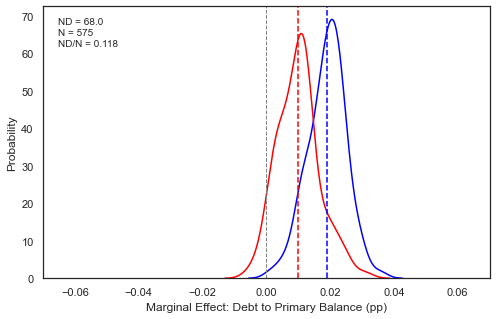

In [15]:
tp = 1

filtro_D1P = (DFK['D1P'] < tp) & (DFK['M'] == "linear")
filtro_D1NDP = (DFK['D1NDP'] < tp) & (DFK['M'] == "linear")
DFK_D1P = DFK[filtro_D1P]
DFK_D1NDP = DFK[filtro_D1NDP]

# Ajustar el estilo de la gráfica para eliminar la cuadrícula
sns.set(style="white", rc={"axes.grid" : False})

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Graficar las distribuciones

sns.kdeplot(data=DFK_D1P, x="ME1", label='Marginal effc. without CC disaster', color='blue', ax=ax)
sns.kdeplot(data=DFK_D1P, x="ME2", label='Marginal effc. with CC disaster', color='red', ax=ax)

# Calcular y dibujar líneas para la media, P95 y P05
for df, color in zip([DFK_D1P["ME1"], DFK_D1NDP["ME2"]], ['blue', 'red']):
    mean = df.mean()
    # p95 = np.percentile(df, 95)
    # p05 = np.percentile(df, 5)
    ax.axvline(mean, color=color, linestyle='--')
    # ax.axvline(p95, color=color, linestyle='--')
    # ax.axvline(p05, color=color, linestyle='--')

# Ajustar los títulos y etiquetas
ax.set_xlabel('Marginal Effect: Debt to Primary Balance (pp)')
ax.set_ylabel('Probability')

superior = 0.07
inferior = -0.07

ticks = np.arange(inferior, superior + 0.005, 0.005)  
plt.xlim(inferior, superior)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

plt.figtext(0.15, 0.83, f'ND = {dfr.ND.sum()}')
plt.figtext(0.15, 0.80, f'N = {dfr.shape[0]}')
plt.figtext(0.15, 0.77, f'ND/N = {round(dfr.ND.sum()/dfr.shape[0],3)}')

plt.show()



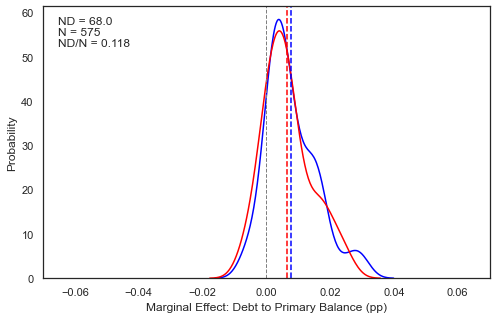

In [16]:
tp = 1

filtro_D1P = (DFK['D1P'] < tp) & (DFK['M'] == "cuadratic")
filtro_D1NDP = (DFK['D1NDP'] < tp) & (DFK['M'] == "cuadratic")
DFK_D1P = DFK[filtro_D1P]
DFK_D1NDP = DFK[filtro_D1NDP]

# Ajustar el estilo de la gráfica para eliminar la cuadrícula
sns.set(style="white", rc={"axes.grid" : False})

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Graficar las distribuciones

sns.kdeplot(data=DFK_D1P, x="ME1", label='Marginal effc. without CC disaster', color='blue', ax=ax)
sns.kdeplot(data=DFK_D1P, x="ME2", label='Marginal effc. with CC disaster', color='red', ax=ax)

# Calcular y dibujar líneas para la media, P95 y P05
for df, color in zip([DFK_D1P["ME1"], DFK_D1NDP["ME2"]], ['blue', 'red']):
    mean = df.mean()
    # p95 = np.percentile(df, 95)
    # p05 = np.percentile(df, 5)
    ax.axvline(mean, color=color, linestyle='--')
    # ax.axvline(p95, color=color, linestyle='--')
    # ax.axvline(p05, color=color, linestyle='--')

# Ajustar los títulos y etiquetas
ax.set_xlabel('Marginal Effect: Debt to Primary Balance (pp)')
ax.set_ylabel('Probability')

superior = 0.07
inferior = -0.07

ticks = np.arange(inferior, superior + 0.005, 0.005)  
plt.xlim(inferior, superior)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

plt.figtext(0.15, 0.83, f'ND = {dfr.ND.sum()}')
plt.figtext(0.15, 0.80, f'N = {dfr.shape[0]}')
plt.figtext(0.15, 0.77, f'ND/N = {round(dfr.ND.sum()/dfr.shape[0],3)}')

plt.show()



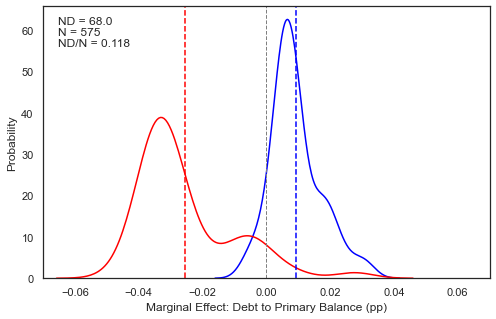

In [17]:
tp = 1

filtro_D1P = (DFK['D1P'] < tp) & (DFK['M'] == "cubic")
filtro_D1NDP = (DFK['D1NDP'] < tp) & (DFK['M'] == "cubic")
DFK_D1P = DFK[filtro_D1P]
DFK_D1NDP = DFK[filtro_D1NDP]

# Ajustar el estilo de la gráfica para eliminar la cuadrícula
sns.set(style="white", rc={"axes.grid" : False})

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Graficar las distribuciones

sns.kdeplot(data=DFK_D1P, x="ME1", label='Marginal effc. without CC disaster', color='blue', ax=ax)
sns.kdeplot(data=DFK_D1P, x="ME2", label='Marginal effc. with CC disaster', color='red', ax=ax)

# Calcular y dibujar líneas para la media, P95 y P05
for df, color in zip([DFK_D1P["ME1"], DFK_D1NDP["ME2"]], ['blue', 'red']):
    mean = df.mean()
    # p95 = np.percentile(df, 95)
    # p05 = np.percentile(df, 5)
    ax.axvline(mean, color=color, linestyle='--')
    # ax.axvline(p95, color=color, linestyle='--')
    # ax.axvline(p05, color=color, linestyle='--')

# Ajustar los títulos y etiquetas
ax.set_xlabel('Marginal Effect: Debt to Primary Balance (pp)')
ax.set_ylabel('Probability')

superior = 0.07
inferior = -0.07

ticks = np.arange(inferior, superior + 0.005, 0.005)  
plt.xlim(inferior, superior)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

plt.figtext(0.15, 0.83, f'ND = {dfr.ND.sum()}')
plt.figtext(0.15, 0.80, f'N = {dfr.shape[0]}')
plt.figtext(0.15, 0.77, f'ND/N = {round(dfr.ND.sum()/dfr.shape[0],3)}')

plt.show()


In [ ]:
# https://github.com/dazhwu/pydynpd/tree/main;%20https://github.com/dazhwu/pydynpd

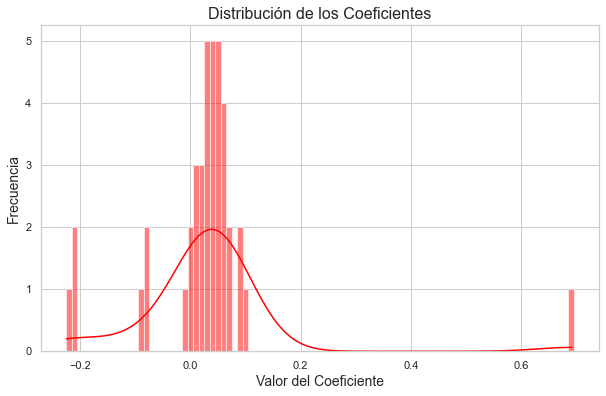

In [348]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que los números están en el formato correcto y de haber corregido cualquier error tipográfico
numeros_adicionales = [
    0.01, 0.03, -0.06, -0.07, -0.02, 0.00, 0.08, 0.01, 0.03,
    0.01, 0.02, 0.008, 0.024, 0.00, 0.03, -0.18, -0.02, 0.02,
    0.04, 0.02, 0.008, 0.080, 0.009, 0.011, 0.009, 0.014, 0.01,
    0.15, -0.05, 0.17, 0.027, 0.031, 0.033, 0.038, 0.026, 0.060,
    0.0367, 0.0455, 0.0563, 0.0415, 0.054, 0.078, 0.0240, 0.0426,
    0.064, 0.022, 0.0727, 0.041, 0.011, 0.043, 0.059, 0.026, 0.087
]


numeros_adicionales = [0.039, 0.047, 0.057, 0.060,
    0.034,
    0.055, 0.086,
    0.063, 0.089,
    0.048, 0.072,
    0.05, 0.10,
    0.04, 0.06,
    0.030, 0.046,
    -0.2080,
    -0.0805,
    0.035, 0.040,
    0.032, 0.037,
    0.033, 0.072,
    0.020, 0.038,
    -0.208, -0.225,
    -0.081, -0.086,
    0.015, 0.023,
    -0.01, 0.01,
    0.003, 0.025,
    0.013,
    -0.001, 0.692]

# Configura el estilo del gráfico de seaborn
sns.set(style="whitegrid")

# Crea un gráfico de distribución con histograma y una curva de densidad de kernel
plt.figure(figsize=(10, 6))
sns.histplot(numeros_adicionales, kde=True, color='red', binwidth=0.01)

# Agrega un título y etiquetas para los ejes
plt.title('Distribución de los Coeficientes', fontsize=16)
plt.xlabel('Valor del Coeficiente', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Muestra el gráfico
plt.show()


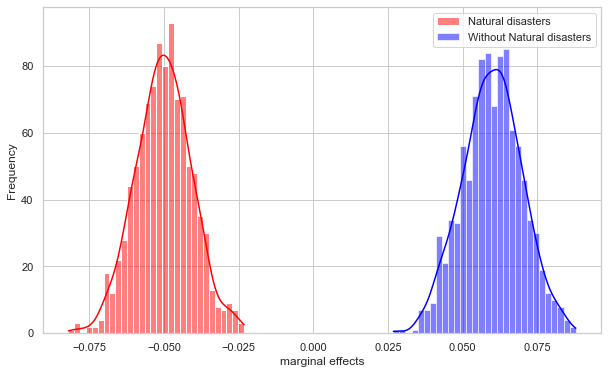

In [349]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simular números para dos distribuciones
dist1 = np.random.normal(loc=-0.05, scale=0.01, size=1000)  # Distribución centrada en -0.05
dist2 = np.random.normal(loc=0.06, scale=0.01, size=1000)  # Distribución centrada en 0.06

# Establece el estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico con las dos distribuciones
plt.figure(figsize=(10, 6))

sns.histplot(dist1, color="red", kde=True, bins=30, label='Natural disasters')
sns.histplot(dist2, color="blue", kde=True, bins=30, label='Without Natural disasters')

# Añadir leyenda
plt.legend()

# Añadir títulos y etiquetas
# plt.title('Comparación de Dos Distribuciones')
plt.xlabel('marginal effects')
plt.ylabel('Frequency')

# Mostrar el gráfico
plt.show()


Cuadratic

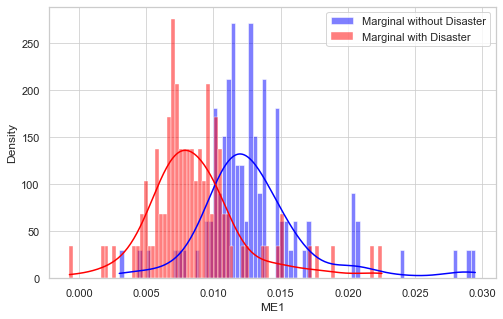

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.histplot(data=DFK[(DFK['D2P'] < 0.1)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue')
# sns.histplot(data=DFK[(DFK['D2NDP'] < 0.1)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red')

sns.histplot(data=DFK[(DFK['D2P'] < 1) & (DFK['M'] == 6)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue')
sns.histplot(data=DFK[(DFK['D2NDP'] < 1) & (DFK['M'] == 6)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red')

ax.legend(title=None)
plt.show()

Cubic

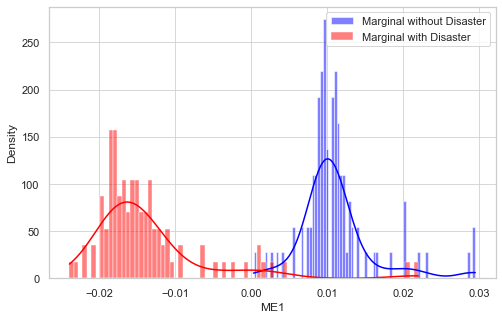

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# sns.histplot(data=DFK[(DFK['D3P'] < 0.1)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue')
# sns.histplot(data=DFK[(DFK['D3NDP'] < 0.1)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red')

sns.histplot(data=DFK[(DFK['D3P'] < 1) & (DFK['M'] == 8)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue')
sns.histplot(data=DFK[(DFK['D3NDP'] < 1) & (DFK['M'] == 8)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red')


# sns.histplot(data=DFK, x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue')
# sns.histplot(data=DFK, x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red')


ax.legend(title=None)
plt.show()

All at once

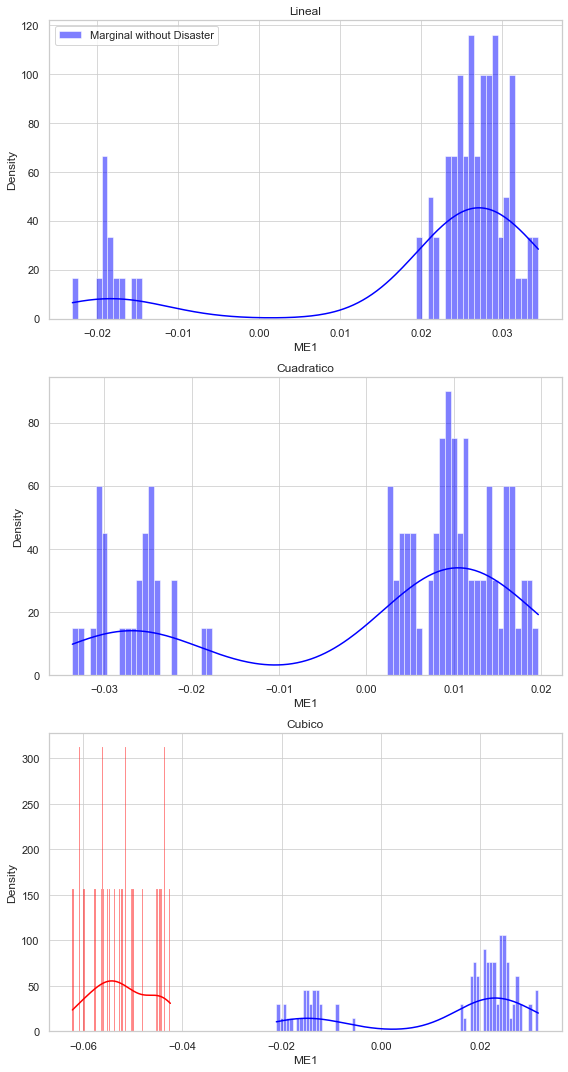

In [156]:
# Setting up the figure with 3 subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # Adjust the size as needed

# Plot for D1P
# sns.histplot(data=DFK[(DFK['D1P'] < 0.1)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue', ax=axes[0])
# sns.histplot(data=DFK[(DFK['D1NDP'] < 0.1)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red', ax=axes[0])
# axes[0].legend()
# # axes[0].set_title('D1P vs D1NDP')

# # Plot for D2P
# sns.histplot(data=DFK[(DFK['D2P'] < 0.1)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue', ax=axes[1])
# sns.histplot(data=DFK[(DFK['D2NDP'] < 0.1)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red', ax=axes[1])
# # axes[1].legend()
# # axes[1].set_title('D2P vs D2NDP')

# # Plot for D3P
# sns.histplot(data=DFK[(DFK['D3P'] < 0.1)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue', ax=axes[2])
# sns.histplot(data=DFK[(DFK['D3NDP'] < 0.1)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red', ax=axes[2])
# # axes[2].legend()
# # axes[2].set_title('D3P vs D3NDP')



# Plot for D1P
sns.histplot(data=DFK[(DFK['D1P'] < 0.1) & (DFK['M'] == 3)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue', ax=axes[0])
sns.histplot(data=DFK[(DFK['D1NDP'] < 0.1) & (DFK['M'] == 3)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red', ax=axes[0])
axes[0].legend()
axes[0].set_title('Lineal')

# Plot for D2P
sns.histplot(data=DFK[(DFK['D2P'] < 0.1) & (DFK['M'] == 5)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue', ax=axes[1])
sns.histplot(data=DFK[(DFK['D2NDP'] < 0.1) & (DFK['M'] == 5)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red', ax=axes[1])
# axes[1].legend()
axes[1].set_title('Cuadratico')

# Plot for D3P
sns.histplot(data=DFK[(DFK['D3P'] < 0.1) & (DFK['M'] == 7)], x="ME1", bins=80, kde=True, stat="density", label='Marginal without Disaster', color='blue', ax=axes[2])
sns.histplot(data=DFK[(DFK['D3NDP'] < 0.1) & (DFK['M'] == 7)], x="ME2", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red', ax=axes[2])
# axes[2].legend()
axes[2].set_title('Cubico')


# Adjust the layout
plt.savefig(f"{y[0]}.jpeg", dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
# np.random.seed(10)
# random.seed(10)

# modelos = 1000
# #################################################################################################
# # ESTIMATING THE COMBINATIONS OF DIFFERENT MODELS
# #################################################################################################

# X1 = X1 = ["ND_1"]  #LINEAR FIX COVARIATES

# CTE = []; 

# # MARGINAL EFFECT

# # MARGINAL EFFECT + NATURAL DISASTER
# ND = []; NDP = []; 

# # GENERAL STATISTICS
# R2 = []; R2A = []; BIC = []; AIC = [];  XLIST= []; M = []

# for k in tqdm(range(0, modelos)): # WITHIN THE POSSIBLE COMBINATIONS OF CONTROLS

#     gc = random.choice(CCX) # CHOOSE ONE OF 10K

#     for XS in [X1]: # FOR EACH DEGREE OF ESTIMATION

#         # VARIABLE SELECTION
#         dbpe = dfx[ y + XS + gc] 
#         dbpe = dbpe.dropna()
#         Xlist = XS + gc
#         X = dbpe[Xlist]
#         Y = dbpe[y]

#         # MODEL ESTIMATION
#         model = sm.OLS(Y, sm.add_constant(X))
#         results = model.fit(cov_type='HC3')

#         #################################################################################################
#         # ESTIMATING THE MARGINAL EFFECT ON THE AVERAGE DEBT
#         #################################################################################################

#         ###############################################
#         # MARGINAL EFFECT WITHOUT DISASTER

#         ############################################## LINEAR

#         nd = round(results.params["ND_1"], 10)
#         ndp = round(results.pvalues["ND_1"], 10)
        
#         cte = results.params["const"]
#         r2  = results.rsquared
#         r2a = results.rsquared_adj
#         bic = results.bic
#         aic = results.aic

#         ##############################################
                
#         CTE.append(cte); ND.append(nd); NDP.append(ndp)
        # R2.append(r2); R2A.append(r2a); BIC.append(bic); AIC.append(aic); XLIST.append(list(gc)); M.append(len(XS))

        ##############################################

    ##############################################
    # DATAFRAME

dfresults = pd.DataFrame(
           list(zip(CTE, ND, NDP,
               R2, R2A, BIC, AIC, XLIST, M)),

        columns = ['CTE', 'ND', 'NDP',
                   'R2', 'R2A', 'BIC', 'AIC', 'XLIST', 'M']
    )
DFK = dfresults.sort_values(by = ["BIC"])

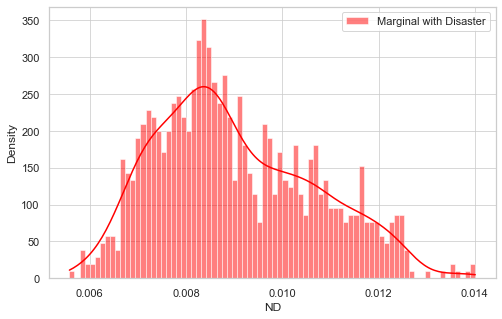

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.histplot(data=DFK[(DFK['NDP'] < 1)], x="ND", bins=80, kde=True, stat="density", label='Marginal with Disaster', color='red')

ax.legend(title=None)
plt.savefig(f"{y[0]}_ND.jpeg", dpi=300)

plt.show()

### Arellano-Bond

In [ ]:
np.random.seed(10)
random.seed(10)

modelos = 100
#################################################################################################
# ESTIMATING THE COMBINATIONS OF DIFFERENT MODELS
#################################################################################################

CTE = []; 

# MARGINAL EFFECT
D1 = []; D1P = []; D2 = []; D2P = []; D3 = []; D3P = []
ME1 = []

# MARGINAL EFFECT + NATURAL DISASTER
ND = []; NDP = []; 
D1ND = []; D1NDP = []; D2ND = []; D2NDP = []; D3ND = []; D3NDP = []
ME2 = []

# GENERAL STATISTICS
R2 = []; R2A = []; BIC = []; AIC = [];  XLIST= []; M = []


for k in tqdm(range(0, modelos)): # WITHIN THE POSSIBLE COMBINATIONS OF CONTROLS

    gc = random.choice(CCX) # CHOOSE ONE OF 10K

    for XS in [X1, X2, X3]: # FOR EACH DEGREE OF ESTIMATION

        # VARIABLE SELECTION

        dbpe = dfr[ y + XS + gc + ["WEO_CODE", "DATE"]] 
        
        dependientes = X3 + gc
        try:
            dependientes.remove("PB_1")
        except:
            None
        dependientes = ' '.join(dependientes)

        fijas = X3.copy()
        try:
            fijas.remove("PB_1")
        except:
            None
        fijas = ' '.join(fijas)

        covariables = ' '.join(gc)

        # command_str=f'PB L1.PB {dependientes} | endo(PB) pred({fijas}) iv({covariables}) | collapse'
        # command_str=f'PB L1.PB {dependientes} | endo(PB) pred(D D1ND) iv({covariables}) | collapse'
        # command_str=f'PB L1.PB {dependientes} | endo(PB) pred(D D1ND) | collapse'
        command_str=f'PB L1.PB {dependientes} | endo(PB) pred(D) iv({covariables}) | collapse nolevel'
        mydpd = regression.abond(command_str, dfx, ['WEO_CODE', 'DATE'])

        tabla_resultados = mydpd.models[0].regression_table
        tabla_resultados = tabla_resultados.set_index("variable")

        # DMEAN = np.percentile(dbpe["D1"], 75)
        DMEAN = dbpe["D1"].mean()

        #################################################################################################
        # ESTIMATING THE MARGINAL EFFECT ON THE AVERAGE DEBT
        #################################################################################################

        ###############################################
        # MARGINAL EFFECT WITHOUT DISASTER

        d1 = round(tabla_resultados.loc["D1", "coefficient"], 10)
        d1_p = round(tabla_resultados.loc["D1", "p_value"], 10)

        d2 = np.nan
        d2_p = np.nan

        d3 = np.nan
        d3_p = np.nan

        me1 = d1
                     
        ############################################### LINEAR
        # MARGINAL EFFECT WITH DISASTER

##############################################################################
            
        d1nd = round(tabla_resultados.loc["D1ND", "coefficient"], 10)
        d1nd_p = round(tabla_resultados.loc["D1ND", "p_value"], 10)
        d2nd = np.nan
        d2nd_p = np.nan

        d3nd = np.nan
        d3nd_p = np.nan

        me2 = me1 + d1nd

        ############################################## CUADRATIC

        if XS == X2:
            d2 = round(tabla_resultados.loc["D1_2", "coefficient"], 10)
            d2_p = round(tabla_resultados.loc["D1_2", "p_value"], 10)

            d2nd = round(tabla_resultados.loc["D1_2ND", "coefficient"], 10)
            d2nd_p = round(tabla_resultados.loc["D1_2ND", "p_value"], 10)

            me1 = d1 + 2*d2*DMEAN
            me2 = me1 + d1nd + 2*d2nd*DMEAN
                    

        if XS == X3:               
            d2 = round(tabla_resultados.loc["D1_2", "coefficient"], 10)
            d2_p = round(tabla_resultados.loc["D1_2", "p_value"], 10)

            d2nd = round(tabla_resultados.loc["D1_2ND", "coefficient"], 10)
            d2nd_p = round(tabla_resultados.loc["D1_2ND", "p_value"], 10)            

            d3 = round(tabla_resultados.loc["D1_3", "coefficient"], 10)
            d3_p = round(tabla_resultados.loc["D1_3", "p_value"], 10)

            d3nd = round(tabla_resultados.loc["D1_3ND", "coefficient"], 10)
            d3nd_p = round(tabla_resultados.loc["D1_3ND", "p_value"], 10)

            me1 = d1 + 2*d2*DMEAN + 3*d3*(DMEAN**2)
            me2 = me1 + d1nd + 2*d2nd*DMEAN + 3*d3nd*(DMEAN**2)

        ############################################## LINEAR
        # cte = results.params["const"]
        cte = 1
        r2  = 1
        r2a = 1
        bic = 1
        aic = 1

        ##############################################
                
        CTE.append(cte); 

        D1.append(d1); D1P.append(d1_p) ; D2.append(d2); D2P.append(d2_p); D3.append(d3); D3P.append(d3_p)
        ME1.append(me1)

        D1ND.append(d1nd); D1NDP.append(d1nd_p) ; D2ND.append(d2nd); D2NDP.append(d2nd_p); D3ND.append(d3nd); D3NDP.append(d3nd_p)
        ME2.append(me2)
        R2.append(r2); R2A.append(r2a); BIC.append(bic); AIC.append(aic); XLIST.append(list(gc)); M.append(len(XS))

        ##############################################

    ##############################################
    # DATAFRAME

dfresults = pd.DataFrame(
           list(zip(CTE, 
               D1, D1P, D2, D2P, D3, D3P,
               D1ND, D1NDP, D2ND, D2NDP, D3ND, D3NDP, 
               ME1, ME2, 
               R2, R2A, BIC, AIC, XLIST, M)),

        columns = ['CTE', 
                   'D1', 'D1P', 'D2', 'D2P', 'D3', 'D3P',
                   'D1ND', 'D1NDP', 'D2ND', 'D2NDP', 'DND3', 'D3NDP',
                   'ME1', 'ME2', 
                   'R2', 'R2A', 'BIC', 'AIC', 'XLIST', 'M']
    )
DFK = dfresults.sort_values(by = ["BIC"])

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:20,  4.72it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+---------------------+------------+---------------------+------------+-----------+-----+
|          PB         |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+---------------------+------------+---------------------+------------+-----------+-----+
|        L1.PB        | 0.4542225  |      0.1272147      | 3.5705204  | 0.0003563 | *** |
|          D1         | -0.0988843 |      0.4055240      | -0.2438433 | 0.8073522 |     |
|         D1_2        | 0.2095390  |      0.5453968      | 0.3841955  | 0.7008336 |     |
|         D1_3        | -0.0826554 |      0.2084880      | -0.3964517 | 0.6917718 |     |
|         

  2%|▏         | 2/100 [00:00<00:20,  4.89it/s]

+------------------+------------+---------------------+------------+-----------+----+
|        PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+------------------+------------+---------------------+------------+-----------+----+
|      L1.PB       | 0.4390926  |      0.1510005      | 2.9078883  | 0.0036388 | ** |
|        D1        | 0.0948451  |      0.1971637      | 0.4810473  | 0.6304829 |    |
|       D1_2       | -0.0422591 |      0.2687647      | -0.1572344 | 0.8750601 |    |
|       D1_3       | 0.0107251  |      0.1038532      | 0.1032713  | 0.9177477 |    |
|       D1ND       | -0.8505241 |      2.4860426      | -0.3421197 | 0.7322608 |    |
|      D1_2ND      | 1.6471987  |      4.8271006      | 0.3412398  | 0.7329231 |    |
|      D1_3ND      | -0.9447157 |      2.8065936      | -0.3366058 | 0.7364141 |    |
|       ND_1       | 0.1318435  |      0.3709478      | 0.3554234  | 0.7222724 |    |
|  EXPORTS_GDP_1   | 0.0251067  |      0.0624956      

  3%|▎         | 3/100 [00:00<00:19,  4.94it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------------+------------+---------------------+------------+-----------+---+
|          PB          |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+----------------------+------------+---------------------+------------+-----------+---+
|        L1.PB         | 0.3476584  |      0.1469003      | 2.3666273  | 0.0179510 | * |
|          D1          | 0.0407501  |      0.3291708      | 0.1237962  | 0.9014766 |   |
|         D1_2         | -0.0137269 |      0.4685673      | -0.0292955 | 0.9766289 |   |
|         D1_3         | 0.0059097  |      0.1834802      | 0.0322090  | 0.9743054 |   |
|         D1ND   

  4%|▍         | 4/100 [00:00<00:18,  5.17it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------------+------------+---------------------+------------+-----------+-----+
|            PB           |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------------------------+------------+---------------------+------------+-----------+-----+
|          L1.PB          | 0.3142098  |      0.0884393      | 3.5528287  | 0.0003811 | *** |
|            D1           | -0.0614231 |      0.2145560      | -0.2862800 | 0.7746637 |     |
|           D1_2          | 0.1074520  |      0.3145091      | 0.3416497  | 0.7326145 |     |
|           D1_3          | -0.0455279 |      0.1296148      | -0.3512553 | 

  6%|▌         | 6/100 [00:01<00:16,  5.55it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 53                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+----------------+------------+---------------------+------------+-----------+----+
|     L1.PB      | 0.3786182  |      0.1424008      | 2.6588204  | 0.0078415 | ** |
|       D1       | 0.2003811  |      0.3481993      | 0.5754782  | 0.5649679 |    |
|      D1_2      | -0.1934561 |      0.4721551      | -0.4097299 | 0.6820041 |    |
|      D1_3      | 0.0743087  |      0.1825081      | 0.4071526  | 0.6838959 |    |
|      D1ND      | -0.3494127 |      2.2534046      

  7%|▋         | 7/100 [00:01<00:16,  5.60it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+---+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+----------------+------------+---------------------+------------+-----------+---+
|     L1.PB      | 0.5272435  |      0.2066005      | 2.5519950  | 0.0107108 | * |
|       D1       | -0.0206345 |      0.3288340      | -0.0627507 | 0.9499651 |   |
|      D1_2      | 0.1061882  |      0.4568592      | 0.2324308  | 0.8162034 |   |
|      D1_3      | -0.0416156 |      0.1797289      | -0.2315465 | 0.8168903 |   |
|      D1ND      | 0.4256175  |      2.8977969      | 0.146

  8%|▊         | 8/100 [00:01<00:16,  5.49it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+-----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------+------------+---------------------+------------+-----------+-----+
|     L1.PB      | 0.5008048  |      0.1091246      | 4.5892949  | 0.0000044 | *** |
|       D1       | 0.2288632  |      0.3084418      | 0.7419981  | 0.4580885 |     |
|      D1_2      | -0.2552761 |      0.4158532      | -0.6138612 | 0.5393071 |     |
|      D1_3      | 0.0909751  |      0.1588642      | 0.5726598  | 0.5668751 |     |
|      D1ND      | 0.1745273  |      1.843768

  9%|▉         | 9/100 [00:01<00:16,  5.41it/s]


 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------------+------------+---------------------+------------+-----------+---+
|            PB           |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+-------------------------+------------+---------------------+------------+-----------+---+
|          L1.PB          | 0.5363384  |      0.2280173      | 2.3521834  | 0.0186636 | * |
|            D1           | 0.1528634  |      0.3877512      | 0.3942306  | 0.6934108 |   |
|           D1_2          | -0.1303442 |      0.5239768      | -0.2487595 | 0.8035468 |   |
|           D1_3          | 0.0542269  |      0.2041576      | 0.2656127  | 0.7905375 |   |
|           D1ND          | -0.7776057 |      2.488

 10%|█         | 10/100 [00:01<00:16,  5.48it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+--------------+------------+---------------------+------------+-----------+-----+
|      PB      |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+--------------+------------+---------------------+------------+-----------+-----+
|    L1.PB     | 0.5515791  |      0.0885931      | 6.2259853  | 0.0000000 | *** |
|      D1      | 0.2349424  |      0.2656807      | 0.8843035  | 0.3765324 |     |
|     D1_2     | -0.2558415 |      0.3703170      | -0.6908715 | 0.4896463 |     |
|     D1_3     | 0.0898200  |      0.1420880      | 0.6321438  | 0.5272929 |     |
|     D1ND     | 0.6332215  |      2.3577646      | 0.26856

 12%|█▏        | 12/100 [00:02<00:17,  5.12it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+--------------+------------+---------------------+------------+-----------+-----+
|      PB      |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+--------------+------------+---------------------+------------+-----------+-----+
|    L1.PB     | 0.5515791  |      0.0885931      | 6.2259853  | 0.0000000 | *** |
|      D1      | 0.2349424  |      0.2656807      | 0.8843035  | 0.3765324 |     |
|     D1_2     | -0.2558415 |      0.3703170      | -0.6908715 | 0.4896463 |     |
|     D1_3     | 0.0898200  |      0.1420880      | 0.6321438  | 0.5272929 |     |
|     D1ND     | 0.6332215  |      2.3577646      | 0.26856

 13%|█▎        | 13/100 [00:02<00:16,  5.33it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 53                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+---+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+----------------+------------+---------------------+------------+-----------+---+
|     L1.PB      | 0.4421409  |      0.2167695      | 2.0396820  | 0.0413820 | * |
|       D1       | 0.0999371  |      0.3396071      | 0.2942727  | 0.7685495 |   |
|      D1_2      | -0.0700503 |      0.4586221      | -0.1527408 | 0.8786027 |   |
|      D1_3      | 0.0290294  |      0.1770815      | 0.1639327  | 0.8697842 |   |
|      D1ND      | -0.5605587 |      1.7246345      | -0.32

 14%|█▍        | 14/100 [00:02<00:16,  5.18it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+--------------+------------+---------------------+------------+-----------+---+
|      PB      |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+--------------+------------+---------------------+------------+-----------+---+
|    L1.PB     | 0.4293891  |      0.1901300      | 2.2583971  | 0.0239209 | * |
|      D1      | 0.2028405  |      0.3361414      | 0.6034380  | 0.5462174 |   |
|     D1_2     | -0.1955662 |      0.4577140      | -0.4272673 | 0.6691847 |   |
|     D1_3     | 0.0742168  |      0.1767171      | 0.4199754  | 0.6745034 |   |
|     D1ND     | -1.4148418 |      2.5264211      | -0.5600182 | 0.575467

 15%|█▌        | 15/100 [00:02<00:16,  5.07it/s]


 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------------+------------+---------------------+------------+-----------+-----+
|            PB           |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------------------------+------------+---------------------+------------+-----------+-----+
|          L1.PB          | 0.5660588  |      0.1443289      | 3.9220053  | 0.0000878 | *** |
|            D1           | 0.0390341  |      0.3390716      | 0.1151206  | 0.9083495 |     |
|           D1_2          | 0.0267743  |      0.4534929      | 0.0590401  | 0.9529202 |     |
|           D1_3          | -0.0150432 |      0.1715031      | -0.0877138 | 0.9301042 |     |
|           D1ND          | 0.7321446

 16%|█▌        | 16/100 [00:03<00:16,  5.03it/s]


Hansen test of overid. restrictions: chi(42) = 11.085 Prob > Chi2 = 1.000
Arellano-Bond test for AR(1) in first differences: z = -1.75 Pr > z =0.081
Arellano-Bond test for AR(2) in first differences: z = -1.84 Pr > z =0.066

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-----------------------+------------+---------------------+-------------+-----------+-----+
|           PB          |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+-----------------------+------------+---------------------+-------------+-----------+-----+
|         L1.PB         | 0.0678421  |      0.0277499      |  2.4447721  | 0.0144944 |  *  |
|           D1          | 0.1410793  |    

 17%|█▋        | 17/100 [00:03<00:16,  5.15it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 53                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+-----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------+------------+---------------------+------------+-----------+-----+
|     L1.PB      | 0.4507065  |      0.0991441      | 4.5459730  | 0.0000055 | *** |
|       D1       | 0.0370718  |      0.1791856      | 0.2068903  | 0.8360955 |     |
|      D1_2      | 0.0280085  |      0.2492949      | 0.1123511  | 0.9105451 |     |
|      D1_3      | -0.0152481 |      0.0965248      | -0.1579707 | 0.8744799 |     |
|      D1ND      | -0.2756651 |      2.596500

 18%|█▊        | 18/100 [00:03<00:15,  5.14it/s]


 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+-----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------+------------+---------------------+------------+-----------+-----+
|     L1.PB      | 0.2967090  |      0.0906328      | 3.2737485  | 0.0010613 |  ** |
|       D1       | -0.0033904 |      0.3713878      | -0.0091290 | 0.9927162 |     |
|      D1_2      | 0.0383434  |      0.5078230      | 0.0755055  | 0.9398125 |     |
|      D1_3      | -0.0118733 |      0.1954878      | -0.0607366 | 0.9515690 |     |
|      D1ND      | 0.7574766  |      1.0583754      | 0.7156974  | 0.4741782 |     |
|     D1_2ND   

 20%|██        | 20/100 [00:03<00:15,  5.31it/s]


 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------------+------------+---------------------+------------+-----------+-----+
|        PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------------------+------------+---------------------+------------+-----------+-----+
|      L1.PB       | 0.3323899  |      0.1049548      | 3.1669817  | 0.0015403 |  ** |
|        D1        | 0.1804547  |      0.2744600      | 0.6574898  | 0.5108661 |     |
|       D1_2       | -0.1931437 |      0.3705886      | -0.5211810 | 0.6022407 |     |
|       D1_3       | 0.0795432  |      0.1430650      | 0.5559931  | 0.5782156 |     |
|       D1ND       | 0.0728758

 21%|██        | 21/100 [00:03<00:15,  5.25it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 53                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+--------------+------------+---------------------+------------+-----------+-----+
|      PB      |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+--------------+------------+---------------------+------------+-----------+-----+
|    L1.PB     | 0.4838351  |      0.1328117      | 3.6430157  | 0.0002695 | *** |
|      D1      | -0.0079959 |      0.2895704      | -0.0276129 | 0.9779709 |     |
|     D1_2     | 0.0852017  |      0.3820783      | 0.2229955  | 0.8235390 |     |
|     D1_3     | -0.0335423 |      0.1443842      | -0.2323127 | 0.8162952 |     |
|     D1ND     | -0.0732859 |      2.3668266      | -0.0309

 22%|██▏       | 22/100 [00:04<00:14,  5.23it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+----------------+------------+---------------------+------------+-----------+----+
|     L1.PB      | 0.3688709  |      0.2033033      | 1.8143868  | 0.0696182 |    |
|       D1       | 0.0214920  |      0.2852496      | 0.0753445  | 0.9399406 |    |
|      D1_2      | 0.0555157  |      0.3811335      | 0.1456594  | 0.8841903 |    |
|      D1_3      | -0.0278838 |      0.1433553      | -0.1945087 | 0.8457776 |    |
|      D1ND      | 0.2554558  |      2.8323182      

 23%|██▎       | 23/100 [00:04<00:15,  5.10it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------------+------------+---------------------+------------+-----------+-----+
|        PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------------------+------------+---------------------+------------+-----------+-----+
|      L1.PB       | 0.3033778  |      0.1008098      | 3.0094068  | 0.0026176 |  ** |
|        D1        | 0.2598146  |      0.3550962      | 0.7316740  | 0.4643676 |     |
|       D1_2       | -0.2639952 |      0.4755912      | -0.5550886 | 0.5788341 |     |
|       D1_3       | 0.0917080  |      0.1795576      | 0.5107442  | 0.6095302 |     |
|       D1ND       | 0.7743441 

 24%|██▍       | 24/100 [00:04<00:15,  5.01it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------+------------+---------------------+------------+-----------+-----+
|     PB     |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------------+------------+---------------------+------------+-----------+-----+
|   L1.PB    | 0.1792682  |      0.0866055      | 2.0699395  | 0.0384580 |  *  |
|     D1     | 0.2922773  |      0.2625866      | 1.1130698  | 0.2656785 |     |
|    D1_2    | -0.3328756 |      0.3596952      | -0.9254379 | 0.3547382 |     |
|    D1_3    | 0.1298199  |      0.1379179      | 0.9412838  | 0.3465595 |     |
|    D1ND    | 0.1820226  |      1.1031816      | 0.1649979  | 0.8689457 

 25%|██▌       | 25/100 [00:04<00:15,  4.78it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------------+------------+---------------------+------------+-----------+-----+
|        PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------------------+------------+---------------------+------------+-----------+-----+
|      L1.PB       | 0.4515048  |      0.1300070      | 3.4729267  | 0.0005148 | *** |
|        D1        | 0.1592090  |      0.3435921      | 0.4633664  | 0.6431018 |     |
|       D1_2       | -0.1240639 |      0.4629529      | -0.2679839 | 0.7887117 |     |
|       D1_3       | 0.0413700  |      0.1748060      | 0.2366625  | 0.8129186 |     |
|       D1ND       | -0.5316356

 26%|██▌       | 26/100 [00:05<00:16,  4.55it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------+------------+---------------------+------------+-----------+---+
|         PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+-------------------+------------+---------------------+------------+-----------+---+
|       L1.PB       | 0.4272716  |      0.1755922      | 2.4333172  | 0.0149612 | * |
|         D1        | -0.0665704 |      0.2531537      | -0.2629643 | 0.7925781 |   |
|        D1_2       | 0.1580281  |      0.3349552      | 0.4717887  | 0.6370776 |   |
|        D1_3       | -0.0612438 |      0.1267189      | -0.4833047 | 0.6288794 |   |
|        D1ND       | -0.4304785 |    

 27%|██▋       | 27/100 [00:05<00:18,  4.03it/s]


 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------+------------+---------------------+------------+-----------+---+
|         PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+-------------------+------------+---------------------+------------+-----------+---+
|       L1.PB       | 0.3904200  |      0.1738360      | 2.2459095  | 0.0247098 | * |
|         D1        | 0.0605527  |      0.2239391      | 0.2703980  | 0.7868541 |   |
|        D1_2       | -0.0141135 |      0.3135246      | -0.0450156 | 0.9640949 |   |
|        D1_3       | 0.0086721  |      0.1213987      | 0.0714350  | 0.9430516 |   |
|        D1ND       | 0.2640252  |      1.4841872      | 0.1778921  | 0.8588077 |   |
|      

 28%|██▊       | 28/100 [00:05<00:17,  4.09it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------------+------------+---------------------+------------+-----------+----+
|        PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+------------------+------------+---------------------+------------+-----------+----+
|      L1.PB       | 0.5611229  |      0.2372618      | 2.3649946  | 0.0180303 | *  |
|        D1        | 0.2662325  |      0.3698786      | 0.7197836  | 0.4716582 |    |
|       D1_2       | -0.3176238 |      0.5052749      | -0.6286159 | 0.5296006 |    |
|       D1_3       | 0.1230550  |      0.1930369      | 0.6374686  | 0.5238197 |    |
|       D1ND       | 0.3840599  |     

 29%|██▉       | 29/100 [00:05<00:17,  4.15it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+----------------+------------+---------------------+------------+-----------+----+
|     L1.PB      | 0.3807075  |      0.1318788      | 2.8867973  | 0.0038918 | ** |
|       D1       | 0.1690435  |      0.3395037      | 0.4979135  | 0.6185450 |    |
|      D1_2      | -0.1608572 |      0.4579592      | -0.3512479 | 0.7254024 |    |
|      D1_3      | 0.0645202  |      0.1770691      | 0.3643789  | 0.7155751 |    |
|      D1ND      | -0.5601765 |      2.3432149      

 30%|███       | 30/100 [00:06<00:16,  4.25it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------------+------------+---------------------+------------+-----------+---+
|        PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+------------------+------------+---------------------+------------+-----------+---+
|      L1.PB       | 0.4316311  |      0.1694509      | 2.5472339  | 0.0108581 | * |
|        D1        | 0.1553058  |      0.4020741      | 0.3862617  | 0.6993029 |   |
|       D1_2       | -0.1355258 |      0.5577112      | -0.2430036 | 0.8080026 |   |
|       D1_3       | 0.0512173  |      0.2163741      | 0.2367070  | 0.8128841 |   |
|       D1ND       | -1.5466767 |      2.9561

 31%|███       | 31/100 [00:06<00:16,  4.29it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+----------------+------------+---------------------+------------+-----------+----+
|     L1.PB      | 0.6004787  |      0.2319650      | 2.5886608  | 0.0096350 | ** |
|       D1       | 0.0648407  |      0.2477952      | 0.2616707  | 0.7935754 |    |
|      D1_2      | -0.0321770 |      0.3366677      | -0.0955749 | 0.9238582 |    |
|      D1_3      | 0.0161870  |      0.1299793      | 0.1245356  | 0.9008912 |    |
|      D1ND      | 0.0715703  |      2.6188755      

 32%|███▏      | 32/100 [00:06<00:15,  4.25it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------------+------------+---------------------+------------+-----------+-----+
|            PB           |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------------------------+------------+---------------------+------------+-----------+-----+
|          L1.PB          | 0.3238670  |      0.0739968      | 4.3767702  | 0.0000120 | *** |
|            D1           | 0.0914590  |      0.2697320      | 0.3390736  | 0.7345543 |     |
|           D1_2          | -0.0849832 |      0.3469492      | -0.2449443 | 0.8064996 |     |
|           D1_3          | 0.0365506  |      0.1305468      | 0.2799809  | 

 33%|███▎      | 33/100 [00:06<00:16,  4.07it/s]


 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------------+------------+---------------------+------------+-----------+-----+
|          PB          |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------------+------------+---------------------+------------+-----------+-----+
|        L1.PB         | 0.5268225  |      0.1005285      | 5.2405298  | 0.0000002 | *** |
|          D1          | 0.2832811  |      0.3306205      | 0.8568167  | 0.3915462 |     |
|         D1_2         | -0.3438578 |      0.4413048      | -0.7791844 | 0.4358711 |     |
|         D1_3         | 0.1344779  |      0.1676241      | 0.8022585  | 0.4224035 |     |
|         D1ND         | -0.1193151 |      1.6982388      

 34%|███▍      | 34/100 [00:07<00:16,  4.04it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+-------------------+------------+---------------------+------------+-----------+-----+
|         PB        |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------------------+------------+---------------------+------------+-----------+-----+
|       L1.PB       | 0.3927553  |      0.1164235      | 3.3735047  | 0.0007422 | *** |
|         D1        | 0.2319680  |      0.3979942      | 0.5828427  | 0.5599992 |     |
|        D1_2       | -0.2448825 |      0.5368784      | -0.4561227 | 0.6483017 |     |
|        D1_3       | 0.0920581  |      0.2038697      | 0.4515533  | 0.6515908 |     |
|        D1ND       | -0

 35%|███▌      | 35/100 [00:07<00:15,  4.25it/s]


 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------------+------------+---------------------+------------+-----------+-----+
|          PB          |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------------+------------+---------------------+------------+-----------+-----+
|        L1.PB         | 0.4314405  |      0.1117570      | 3.8605233  | 0.0001131 | *** |
|          D1          | 0.1423222  |      0.3234480      | 0.4400158  | 0.6599257 |     |
|         D1_2         | -0.1227907 |      0.4420681      | -0.2777643 | 0.7811933 |     |
|         D1_3         | 0.0443692  |      0.1725656      | 0.2571152  | 0.7970899 |     |
| 

 36%|███▌      | 36/100 [00:07<00:14,  4.50it/s]

+----------------------+------------+---------------------+------------+-----------+-----+
|          PB          |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------------+------------+---------------------+------------+-----------+-----+
|        L1.PB         | 0.4314405  |      0.1117570      | 3.8605233  | 0.0001131 | *** |
|          D1          | 0.1423222  |      0.3234480      | 0.4400158  | 0.6599257 |     |
|         D1_2         | -0.1227907 |      0.4420681      | -0.2777643 | 0.7811933 |     |
|         D1_3         | 0.0443692  |      0.1725656      | 0.2571152  | 0.7970899 |     |
|         D1ND         | -1.1069306 |      2.1872382      | -0.5060860 | 0.6127963 |     |
|        D1_2ND        | 2.2579316  |      4.3057819      | 0.5243952  | 0.6000037 |     |
|        D1_3ND        | -1.3731921 |      2.5649084      | -0.5353767 | 0.5923894 |     |
|         ND_1         | 0.1614784  |      0.3225148      | 0.5006855  | 0.6165925 |     |

 37%|███▋      | 37/100 [00:07<00:13,  4.63it/s]


 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+--------------------+------------+---------------------+------------+-----------+----+
|         PB         |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |    |
+--------------------+------------+---------------------+------------+-----------+----+
|       L1.PB        | 0.3705055  |      0.1339088      | 2.7668493  | 0.0056601 | ** |
|         D1         | 0.2500932  |      0.3859245      | 0.6480365  | 0.5169614 |    |
|        D1_2        | -0.2598578 |      0.5303668      | -0.4899587 | 0.6241631 |    |
|        D1_3        | 0.1015906  |      0.2058664      | 0.4934784  | 0.6216746 |    |
|        D1ND        | -1.1114940 |      2.5208558      | -0.4409193 | 0.659271

 38%|███▊      | 38/100 [00:07<00:13,  4.63it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+------------+------------+---------------------+------------+-----------+---+
|     PB     |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+------------+------------+---------------------+------------+-----------+---+
|   L1.PB    | 0.3881084  |      0.1695488      | 2.2890665  | 0.0220755 | * |
|     D1     | 0.0760640  |      0.1714370      | 0.4436849  | 0.6572704 |   |
|    D1_2    | -0.0042031 |      0.2304743      | -0.0182368 | 0.9854499 |   |
|    D1_3    | -0.0020921 |      0.0882419      | -0.0237093 | 0.9810845 |   |
|    D1ND    | 0.2068009  |      1.3772432      | 0.1501557  | 0.8806418 |   |
|   D1_2

 39%|███▉      | 39/100 [00:08<00:13,  4.47it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+-----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------+------------+---------------------+------------+-----------+-----+
|     L1.PB      | 0.5346033  |      0.1038951      | 5.1456073  | 0.0000003 | *** |
|       D1       | 0.2975649  |      0.2857522      | 1.0413391  | 0.2977182 |     |
|      D1_2      | -0.3861288 |      0.3982657      | -0.9695256 | 0.3322830 |     |
|      D1_3      | 0.1553606  |      0.1546230      | 1.0047702  | 0.3150075 |     |
|      D1ND      | -1.0053803 |      1.763614

 40%|████      | 40/100 [00:08<00:12,  4.68it/s]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: WEO_CODE                         Number of obs = 525      
 Time variable: DATE                              Min obs per group: 21    
 Number of instruments = 54                       Max obs per group: 21    
 Number of groups = 25                            Avg obs per group: 21.00 
+----------------+------------+---------------------+------------+-----------+-----+
|       PB       |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------------+------------+---------------------+------------+-----------+-----+
|     L1.PB      | 0.4419705  |      0.1110210      | 3.9809636  | 0.0000686 | *** |
|       D1       | 0.2700746  |      0.4170464      | 0.6475890  | 0.5172508 |     |
|      D1_2      | -0.2951660 |      0.5580875      | -0.5288884 | 0.5968829 |     |
|      D1_3      | 0.1108121  |      0.2111267      | 0.5248609  | 0.5996799 |     |
|      D1ND      | -0.8688992 |      2.276049

KeyboardInterrupt: 